# Diviser dataset annoté en train/val/test

## Imports

In [1]:
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from rasterio.crs import CRS
import pandas as pd
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from shapely import union_all
import numpy as np
from cairosvg import svg2png
from IPython.display import SVG, display
from pathlib import Path
from skmultilearn.model_selection import IterativeStratification
from sklearn.preprocessing import LabelEncoder
import re

## Variables

In [2]:
todays_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

DATASET_FINAL_OUTPUT_PARQUET_PATH = "data/notebook_06/parquet/06b_03_dataset_final.parquet"
DATASET_PROCESSED_PATH = "datasets/supervisely/dataset_processed_20250523-173715"
DATASET_OUTPUT_IMG_PATH = DATASET_PROCESSED_PATH + "/images"
DATASET_OUTPUT_MASKS_PATH = DATASET_PROCESSED_PATH + "/masks"

K_FOLDS = 5
TEST_PERCENT = 1 - (K_FOLDS / (K_FOLDS + 1))
SPLIT_SEED = 42

CORRECT_CRS = CRS.from_epsg(2056)
EPSG_SUISSE = "EPSG:2056"

GRAPHICS_PATH = "data/notebook_06/graphics/"
MAP_TILES_PNG = GRAPHICS_PATH + "06c_01_tiles.png"

# Générer les *_datasets.txt
MAKE_DATASETS_TXT = False

## Charger données

In [3]:
gdf_dataset_validation = gpd.read_file(DATASET_FINAL_OUTPUT_PARQUET_PATH)
print(type(gdf_dataset_validation))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [23]:
gdf_dataset_validation.groupby("dominant_class").size()

dominant_class
I habitat collectif           48
II habitat individuel         48
III administration            47
IV écoles                     48
IX industrie                  48
V commerce                    47
VI restauration               39
VII lieux de rassemblement    48
VIII hôpitaux                 47
X dépôts                      48
XI installations sportives    45
XII piscines couvertes        17
dtype: int64

## Split

### split

In [ ]:
def assign_dataset_stratification(df, 
                                test_size=0.2,
                                n_folds=5, 
                                class_cv_threshold=0.10,
                                area_cv_threshold=0.10,
                                max_attempts=100):
    """
    Stratifies a dataset into train/test and cross-validation folds using iterative stratification.
    Attempts multiple times to achieve coefficient of variation (CV) thresholds for class and area distributions.
    Returns the best result found within the allowed number of attempts.

    Parameters:
        df (pd.DataFrame): Input dataframe with 'dominant_class' and 'area_bin' columns.
        test_size (float): Proportion of the dataset to include in the test split.
        n_folds (int): Number of cross-validation folds.
        class_cv_threshold (float): Maximum allowed CV for class distribution.
        area_cv_threshold (float): Maximum allowed CV for area distribution.
        max_attempts (int): Maximum number of stratification attempts.

    Returns:
        pd.DataFrame: DataFrame with an added 'dataset' column indicating fold assignment.
    """
    print(f"Target: Class CV ≤ {class_cv_threshold:.3f}, Area CV ≤ {area_cv_threshold:.3f}")
    
    best_result = None
    best_class_cv = float('inf')
    best_area_cv = float('inf')
    best_combined_score = float('inf')
    
    for attempt in range(1, max_attempts + 1):
        try:
            # Encode categorical variables for stratification
            le_dom = LabelEncoder()
            le_area = LabelEncoder()
            dom_labels = le_dom.fit_transform(df['dominant_class'])
            area_labels = le_area.fit_transform(df['area_bin'])
            multi_label = np.column_stack([dom_labels, area_labels])

            # Split into train and test sets using iterative stratification
            test_strat = IterativeStratification(n_splits=int(1/test_size), order=2)
            test_splits = list(test_strat.split(df.values, multi_label))
            train_idx, test_idx = test_splits[0]

            # Initialize dataset column; assign test set with a unique value
            df_temp = df.copy()
            df_temp['dataset'] = n_folds
            df_temp.loc[train_idx, 'dataset'] = -1

            # Create cross-validation folds within the training set
            cv_strat = IterativeStratification(n_splits=n_folds, order=2)
            cv_splits = list(cv_strat.split(df_temp.iloc[train_idx].values, multi_label[train_idx]))

            # Assign fold numbers to training samples
            for fold, (_, val_indices) in enumerate(cv_splits):
                original_val_idx = train_idx[val_indices]
                df_temp.loc[original_val_idx, 'dataset'] = fold

            # Assign any unassigned samples to the first fold
            unassigned = df_temp[df_temp['dataset'] == -1]
            if len(unassigned) > 0:
                df_temp.loc[unassigned.index, 'dataset'] = 0

            # Calculate coefficient of variation for class distribution across folds
            class_cvs = []
            for dom_class in df_temp['dominant_class'].unique():
                class_data = df_temp[df_temp['dominant_class'] == dom_class]
                fold_dist = class_data['dataset'].value_counts()
                fold_pcts = fold_dist / len(class_data) * 100
                cv = fold_pcts.std() / fold_pcts.mean() if fold_pcts.mean() > 0 else 0
                class_cvs.append(cv)
            
            # Calculate coefficient of variation for area distribution across folds
            area_cvs = []
            for area_bin in df_temp['area_bin'].unique():
                area_data = df_temp[df_temp['area_bin'] == area_bin]
                fold_dist = area_data['dataset'].value_counts()
                fold_pcts = fold_dist / len(area_data) * 100
                cv = fold_pcts.std() / fold_pcts.mean() if fold_pcts.mean() > 0 else 0
                area_cvs.append(cv)
            
            class_cv = sum(class_cvs) / len(class_cvs)
            area_cv = sum(area_cvs) / len(area_cvs)
            combined_score = (class_cv + area_cv) / 2
            
            # Print progress if improved or at regular intervals
            if attempt % 20 == 0 or combined_score < best_combined_score:
                print(f"  Attempt {attempt}: Class CV: {class_cv:.3f}, Area CV: {area_cv:.3f}")
            
            # Update best result if current attempt is better
            if combined_score < best_combined_score:
                best_combined_score = combined_score
                best_class_cv = class_cv
                best_area_cv = area_cv
                best_result = df_temp.copy()
            
            # Return immediately if thresholds are met
            if class_cv <= class_cv_threshold and area_cv <= area_cv_threshold:
                print(f"Thresholds met on attempt {attempt}")
                print(f"Final distribution:\n{df_temp['dataset'].value_counts().sort_index()}")
                return df_temp
                
        except Exception:
            continue
    
    # Return the best result found if thresholds were not met
    print(f"Best result: Class CV: {best_class_cv:.3f}, Area CV: {best_area_cv:.3f}")
    print(f"Final distribution:\n{best_result['dataset'].value_counts().sort_index()}")
    
    return best_result

# Usage example:
gdf_dataset_validation_split = assign_dataset_stratification(
    gdf_dataset_validation,
    test_size=TEST_PERCENT,
    n_folds=K_FOLDS,
    class_cv_threshold=0.10,
    area_cv_threshold=0.10,
    max_attempts=10000
)

Target: Class CV ≤ 0.100, Area CV ≤ 0.100
  Attempt 1: Class CV: 0.122, Area CV: 0.146
  Attempt 2: Class CV: 0.096, Area CV: 0.144
  Attempt 3: Class CV: 0.128, Area CV: 0.103
  Attempt 5: Class CV: 0.112, Area CV: 0.109
  Attempt 17: Class CV: 0.108, Area CV: 0.098
  Attempt 20: Class CV: 0.115, Area CV: 0.128
  Attempt 40: Class CV: 0.136, Area CV: 0.149
  Attempt 47: Class CV: 0.112, Area CV: 0.091
  Attempt 49: Class CV: 0.100, Area CV: 0.089
Thresholds met on attempt 49
Final distribution:
dataset
0    89
1    88
2    88
3    87
4    89
5    89
Name: count, dtype: int64


### verif visu

In [ ]:
# Determine the number of cross-validation folds (excluding the test set)
k_folds = len(gdf_dataset_validation_split["dataset"].unique()) - 1

# Generate dataset names for each fold and the test set
dataset_names = [f'fold_{i}' for i in range(k_folds)] + ['test']
dataset_ids = list(range(k_folds)) + [k_folds]

# Calculate the percentage of samples in each dataset split
dataset_counts = gdf_dataset_validation_split['dataset'].value_counts()
total_count = len(gdf_dataset_validation_split)
dataset_percentages = {}
for dataset_id, name in zip(dataset_ids, dataset_names):
    if dataset_id in dataset_counts:
        dataset_percentages[name] = (dataset_counts[dataset_id] / total_count) * 100
    else:
        dataset_percentages[name] = 0

# Prepare a summary string with the split percentages for display or reporting
split_info = ', '.join([f"{name}: {dataset_percentages[name]:.1f}%" for name in dataset_names])

# Compute overall class and area bin distributions for reference
overall_class_dist = gdf_dataset_validation_split['dominant_class'].value_counts(normalize=True)
overall_area_dist = gdf_dataset_validation_split['area_bin'].value_counts(normalize=True)

In [24]:
objectives = gdf_dataset_validation_split.groupby("dominant_class").size() / len(gdf_dataset_validation_split) * 100
display(objectives)

dominant_class
I habitat collectif           9.056604
II habitat individuel         9.056604
III administration            8.867925
IV écoles                     9.056604
IX industrie                  9.056604
V commerce                    8.867925
VI restauration               7.358491
VII lieux de rassemblement    9.056604
VIII hôpitaux                 8.867925
X dépôts                      9.056604
XI installations sportives    8.490566
XII piscines couvertes        3.207547
dtype: float64

/tmp/ipykernel_3247976/4192617749.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, va='bottom')


Saved visualization to data/notebook_06/graphics/ch3_postprocessing_dataset_17_distribution_barchart_classe.png


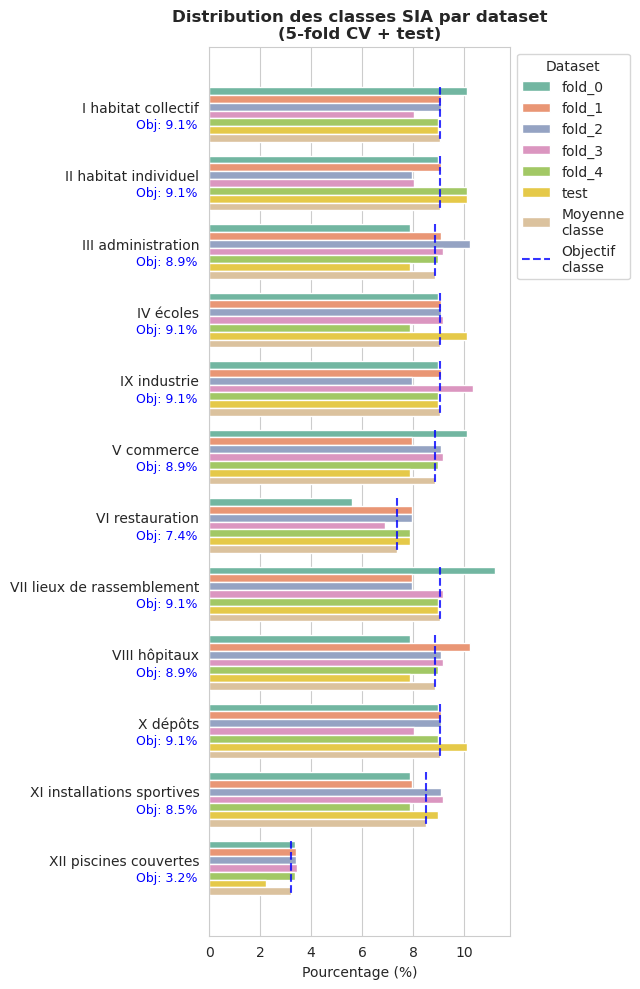

In [ ]:
# Set Seaborn style for all plots
sns.set_style("whitegrid")

# Use a consistent color palette for all datasets and the overall average
palette = sns.color_palette("Set2", n_colors=len(dataset_names) + 1)

# Update matplotlib font and axis parameters for consistent appearance
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Define the order of datasets for legend and plotting
dataset_order = dataset_names + ['Moyenne\nclasse']

# Set default figure size
figsize = (6.5, 10)

# Prepare data for class distribution bar chart
plt.figure(figsize=figsize)

# Collect class distribution data for each dataset
class_data = []
for dataset_id, name in zip(dataset_ids, dataset_names):
    subset = gdf_dataset_validation_split[gdf_dataset_validation_split['dataset'] == dataset_id]
    if len(subset) > 0:
        class_counts = subset['dominant_class'].value_counts(normalize=True)
        for cls, count in class_counts.items():
            class_data.append({
                'Dataset': name,
                'Class': cls,
                'Percentage': count * 100
            })

# Add overall class distribution
for cls, count in overall_class_dist.items():
    class_data.append({
        'Dataset': 'Moyenne\nclasse',
        'Class': cls,
        'Percentage': count * 100
    })

class_df = pd.DataFrame(class_data)

# Sort classes alphabetically and set categorical order
class_df_sorted = class_df.copy()
unique_classes = sorted(class_df['Class'].unique())
class_df_sorted['Class'] = pd.Categorical(class_df_sorted['Class'], categories=unique_classes, ordered=True)
class_df_sorted = class_df_sorted.sort_values('Class')

# Set dataset order for legend consistency
class_df_sorted['Dataset'] = pd.Categorical(
    class_df_sorted['Dataset'], 
    categories=dataset_order, 
    ordered=True
)
class_df_sorted = class_df_sorted.sort_values(['Class', 'Dataset'])

# Plot class distribution as a horizontal bar chart
ax = sns.barplot(x='Percentage', y='Class', hue='Dataset', data=class_df_sorted, 
                palette=palette, hue_order=dataset_order)

# Adjust y-axis labels for better alignment
labels = ax.get_yticklabels()
ax.set_yticklabels(labels, va='bottom') 

# Calculate target class percentages from the overall dataset
objectives = gdf_dataset_validation_split.groupby("dominant_class").size() / len(gdf_dataset_validation_split) * 100
target_percentages = {
    class_name: objectives[class_name] for class_name in unique_classes if class_name in objectives    
}

# Add dashed lines for target class percentages and annotate them
first_line = True
for i, class_name in enumerate(unique_classes):
    if class_name in target_percentages:
        target_pct = target_percentages[class_name]
        actual_pct = overall_class_dist[class_name] * 100
        label = 'Objectif\nclasse' if first_line else None  # Only label the first line for legend
        ax.plot([target_pct, target_pct], [i-0.4, i+0.4], 
                color='blue', linewidth=1.5, alpha=0.8, linestyle='--', 
                solid_capstyle='round', label=label)
        first_line = False
        # Annotate target value below the class name
        ax.text(-0.45, i+0.05, f'Obj: {target_pct:.1f}%', 
            ha='right', va='top', fontsize=9, color='blue')

# Place the legend outside the plot area
plt.legend(title="Dataset", bbox_to_anchor=(1, 1), loc='upper left', frameon=True)
plt.title(f'Distribution des classes SIA par dataset\n({k_folds}-fold CV + test)', fontweight='bold')
plt.xlabel('Pourcentage (%)')
plt.ylabel('')

plt.tight_layout()
file_path = os.path.join(GRAPHICS_PATH, 'ch3_postprocessing_dataset_17_distribution_barchart_classe.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f"Saved visualization to {file_path}")
plt.show()
plt.close()


/tmp/ipykernel_3247976/1870914422.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


Saved visualization to data/notebook_06/graphics/ch3_postprocessing_dataset_16_distribution_barchart_surface.png


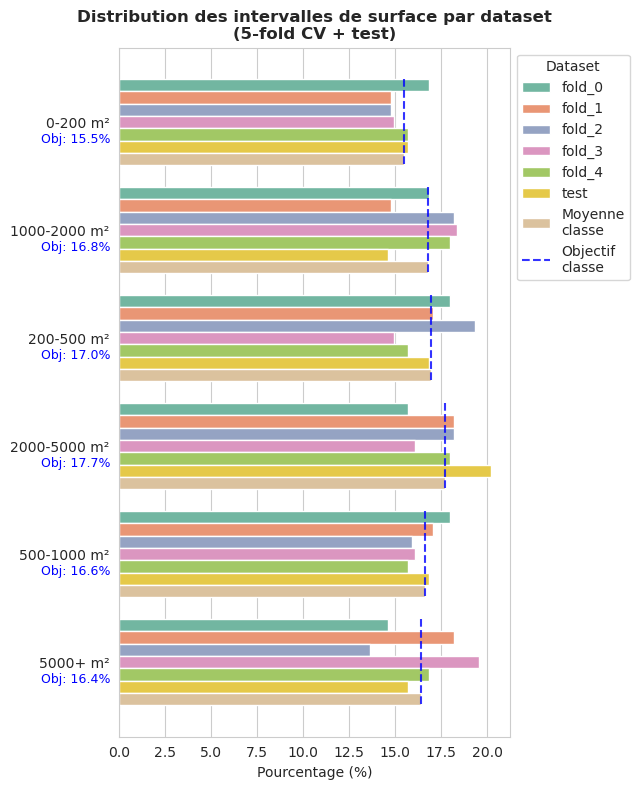

In [ ]:
# Set Seaborn plot style to whitegrid for better readability
sns.set_style("whitegrid")

# Define a consistent color palette for all plots
palette = sns.color_palette("Set2", n_colors=len(dataset_names) + 1)

# Update matplotlib parameters for consistent font sizes
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Specify the order of datasets for legend consistency
dataset_order = dataset_names + ['Moyenne\nclasse']

# Set default figure size
figsize = (6.5, 8)

# Create a new figure for the area bin distribution bar chart
plt.figure(figsize=figsize)

# Calculate the overall distribution of area bins (as percentages)
overall_area_dist = gdf_dataset_validation_split['area_bin'].value_counts(normalize=True).to_dict()

# Prepare data for plotting: compute area bin distribution for each dataset
area_data = []
for dataset_id, name in zip(dataset_ids, dataset_names):
    subset = gdf_dataset_validation_split[gdf_dataset_validation_split['dataset'] == dataset_id]
    if len(subset) > 0:
        area_counts = subset['area_bin'].value_counts(normalize=True)
        for area_bin, count in area_counts.items():
            area_data.append({
                'Dataset': name,
                'Area_Bin': area_bin,
                'Percentage': count * 100
            })

# Add the overall distribution to the data
for area_bin, count in overall_area_dist.items():
    area_data.append({
        'Dataset': 'Moyenne\nclasse',
        'Area_Bin': area_bin,
        'Percentage': count * 100
    })

area_df = pd.DataFrame(area_data)

# Ensure area bins are sorted and categorical for plotting
area_df_sorted = area_df.copy()
unique_area_bins = sorted(area_df['Area_Bin'].unique())
area_df_sorted['Area_Bin'] = pd.Categorical(area_df_sorted['Area_Bin'], categories=unique_area_bins, ordered=True)
area_df_sorted = area_df_sorted.sort_values('Area_Bin')

# Set dataset order for legend and sorting
area_df_sorted['Dataset'] = pd.Categorical(
    area_df_sorted['Dataset'], 
    categories=dataset_order, 
    ordered=True
)
area_df_sorted = area_df_sorted.sort_values(['Area_Bin', 'Dataset'])

# Plot the area bin distribution as a horizontal bar chart
ax = sns.barplot(x='Percentage', y='Area_Bin', hue='Dataset', data=area_df_sorted, 
                palette=palette, hue_order=dataset_order)

# Update y-axis labels to include square meter units
current_labels = [label.get_text() for label in ax.get_yticklabels()]
new_labels = [f"{label} m²" for label in current_labels]
ax.set_yticklabels(new_labels)

# Calculate target percentages for each area bin based on the overall dataset
objectives_area = gdf_dataset_validation_split.groupby("area_bin").size() / len(gdf_dataset_validation_split) * 100
target_percentages_area = {
    area_bin: objectives_area[area_bin] for area_bin in unique_area_bins if area_bin in objectives_area    
}

# Add dashed vertical lines to indicate target percentages for each area bin
first_line = True
for i, area_bin in enumerate(unique_area_bins):
    if area_bin in target_percentages_area:
        target_pct = target_percentages_area[area_bin]
        actual_pct = overall_area_dist[area_bin] * 100
        label = 'Objectif\nclasse' if first_line else None  # Only label the first line for the legend
        ax.plot([target_pct, target_pct], [i-0.4, i+0.4], 
                color='blue', linewidth=1.5, alpha=0.8, linestyle='--', 
                solid_capstyle='round', label=label)
        first_line = False
        # Display target value below the y-tick label
        ax.text(-0.45, i+0.1, f'Obj: {target_pct:.1f}%', 
            ha='right', va='top', fontsize=9, color='blue')

# Place the legend outside the plot for clarity
plt.legend(title="Dataset", bbox_to_anchor=(1, 1), loc='upper left', frameon=True)
plt.title(f'Distribution des intervalles de surface par dataset\n({k_folds}-fold CV + test)', fontweight='bold', fontsize=12)
plt.xlabel('Pourcentage (%)')
plt.ylabel('')

plt.tight_layout()
file_path = os.path.join(GRAPHICS_PATH, 'ch3_postprocessing_dataset_16_distribution_barchart_surface.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f"Saved visualization to {file_path}")
plt.show()
plt.close()

Saved visualization to data/notebook_06/graphics/06c_02_kfold_class_distribution_barchart_5fold.png


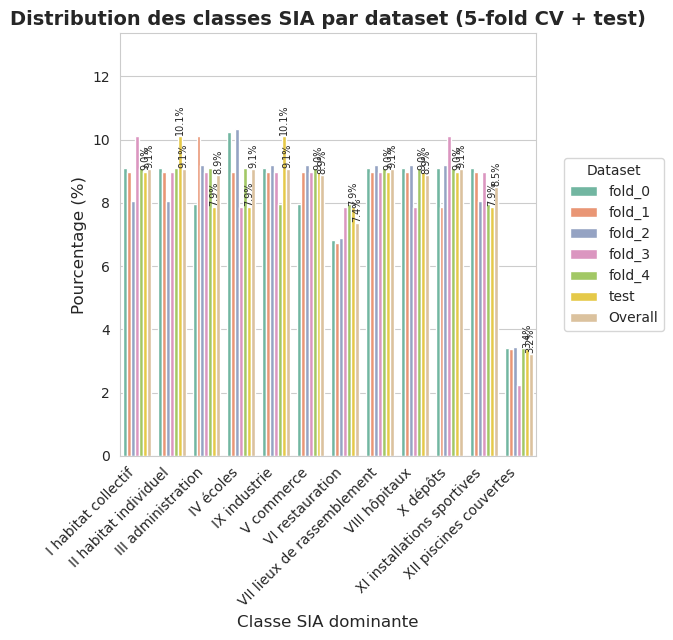

Saved visualization to data/notebook_06/graphics/06c_03_kfold_area_distribution_barchart_5fold.png


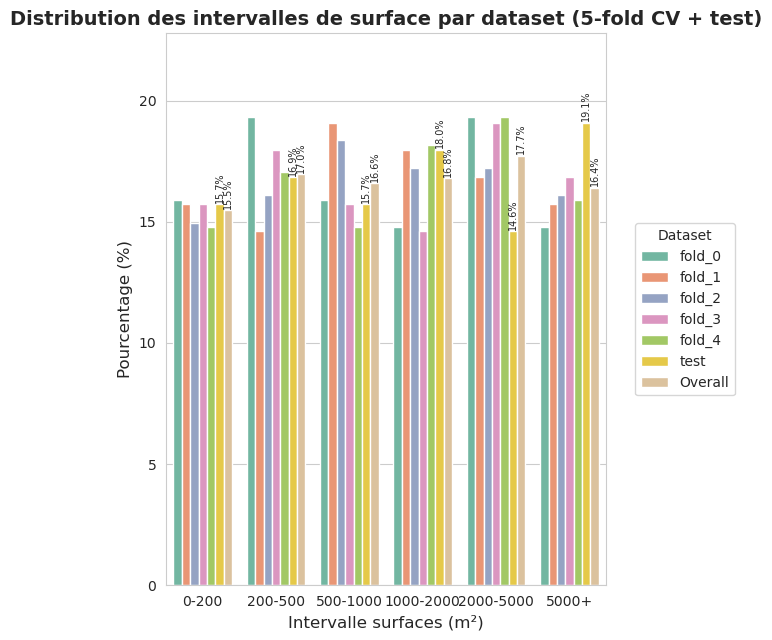

Saved visualization to data/notebook_06/graphics/06c_04_kfold_class_distribution_heatmap_5fold.png


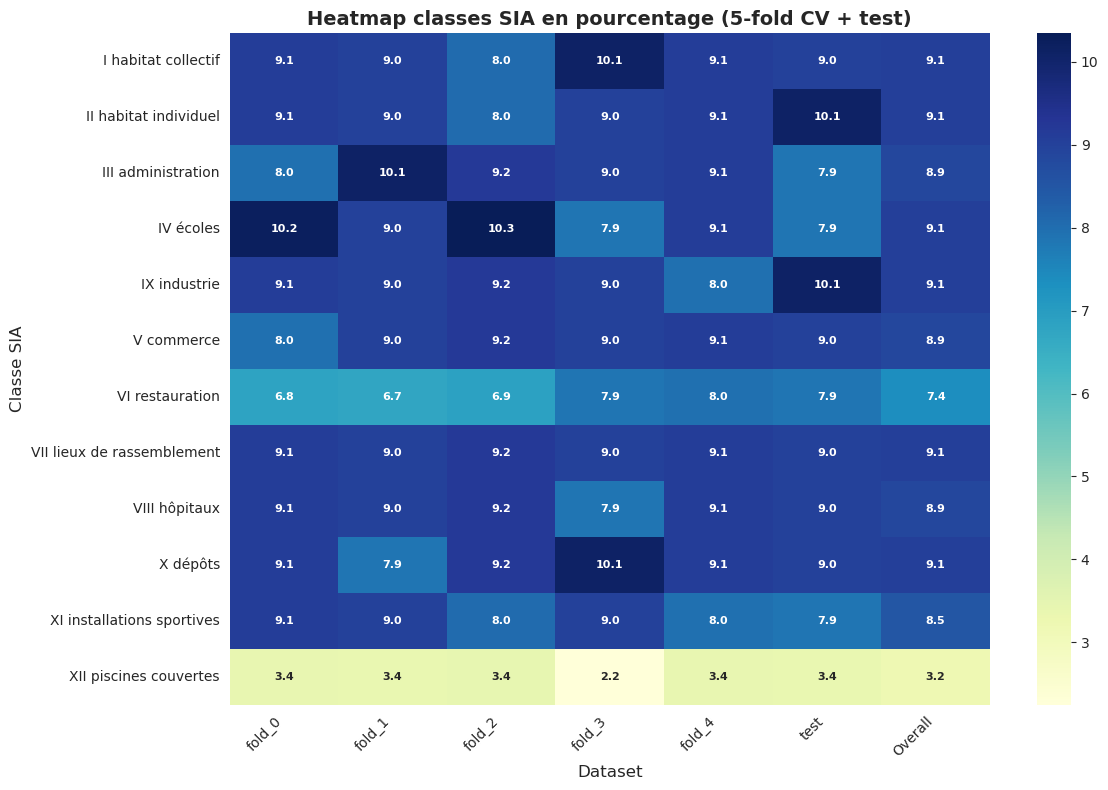

Saved visualization to data/notebook_06/graphics/06c_05_kfold_area_distribution_heatmap_5fold.png


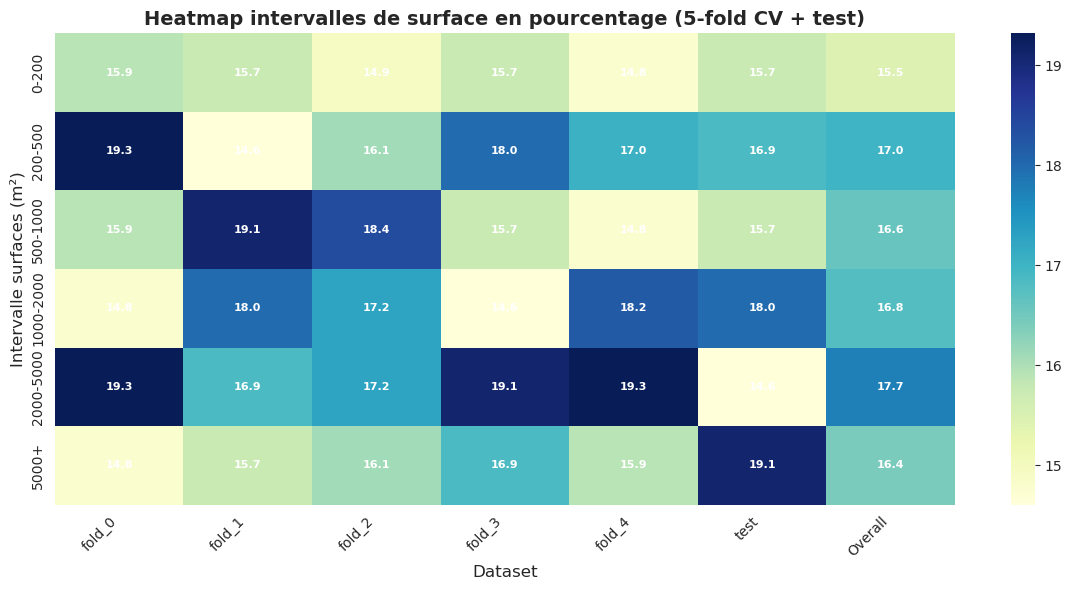

All 5-fold + test visualizations have been created as separate files.


In [ ]:
def create_kfold_distribution_visualizations(gdf_dataset, GRAPHICS_PATH):
    """
    Generates and saves four visualizations showing the distribution of classes and area bins
    across k-folds and the test dataset. Each plot is saved as a separate file.
    """
    # Determine the number of folds from the dataset
    k_folds = len(gdf_dataset["dataset"].unique()) - 1

    # Prepare dataset names and IDs for folds and test set
    dataset_names = [f'fold_{i}' for i in range(k_folds)] + ['test']
    dataset_ids = list(range(k_folds)) + [k_folds]
    
    # Calculate the percentage of samples in each dataset split
    dataset_counts = gdf_dataset['dataset'].value_counts()
    total_count = len(gdf_dataset)
    dataset_percentages = {}
    for dataset_id, name in zip(dataset_ids, dataset_names):
        if dataset_id in dataset_counts:
            dataset_percentages[name] = (dataset_counts[dataset_id] / total_count) * 100
        else:
            dataset_percentages[name] = 0
            
    # Format split percentages for plot titles
    split_info = ', '.join([f"{name}: {dataset_percentages[name]:.1f}%" for name in dataset_names])
    
    # Calculate overall class and area bin distributions
    overall_class_dist = gdf_dataset['dominant_class'].value_counts(normalize=True)
    overall_area_dist = gdf_dataset['area_bin'].value_counts(normalize=True)
    
    # Set seaborn style for all plots
    sns.set_style("whitegrid")
    
    # Use a consistent color palette for all plots
    palette = sns.color_palette("Set2", n_colors=len(dataset_names) + 1)
    
    plt.rcParams.update({
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    
    # Define the order of datasets for legends and plots
    dataset_order = dataset_names + ['Overall']

    figsize = (6.5, 6.5)

    # Bar chart: class distribution by dataset
    plt.figure(figsize=figsize)
    class_data = []
    for dataset_id, name in zip(dataset_ids, dataset_names):
        subset = gdf_dataset[gdf_dataset['dataset'] == dataset_id]
        if len(subset) > 0:
            class_counts = subset['dominant_class'].value_counts(normalize=True)
            for cls, count in class_counts.items():
                class_data.append({
                    'Dataset': name,
                    'Class': cls,
                    'Percentage': count * 100
                })
    # Add overall class distribution
    for cls, count in overall_class_dist.items():
        class_data.append({
            'Dataset': 'Overall',
            'Class': cls,
            'Percentage': count * 100
        })
    class_df = pd.DataFrame(class_data)
    unique_classes = sorted(class_df['Class'].unique())
    class_df['Class'] = pd.Categorical(class_df['Class'], categories=unique_classes, ordered=True)
    class_df['Dataset'] = pd.Categorical(class_df['Dataset'], categories=dataset_order, ordered=True)
    class_df = class_df.sort_values(['Class', 'Dataset'])
    ax = sns.barplot(x='Class', y='Percentage', hue='Dataset', data=class_df, 
                    palette=palette, hue_order=dataset_order)
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 0.5), loc='center left', frameon=True)
    plt.title(f'Distribution des classes SIA par dataset ({k_folds}-fold CV + test)', fontsize=14, fontweight='bold')
    plt.xlabel('Classe SIA dominante', fontsize=12)
    plt.ylabel('Pourcentage (%)', fontsize=12)
    ticks = ax.get_xticks()
    ax.set_xticks(ticks)
    ax.set_xticklabels([label.get_text() for label in ax.get_xticklabels()], rotation=45, ha='right')
    ax.set_ylim(0, ax.get_ylim()[1] + 2.5)
    # Show value labels for test and overall datasets
    for i, container in enumerate(ax.containers):
        dataset_name = dataset_order[i]
        if dataset_name in ['test', 'Overall']:
            labels = ax.bar_label(container, fmt='%.1f%%', fontsize=7, padding=1)
            for label in labels:
                label.set_rotation(90)
                label.set_va('bottom')
                label.set_ha('center')
    plt.tight_layout()
    file_path = os.path.join(GRAPHICS_PATH, f'06c_02_kfold_class_distribution_barchart_{k_folds}fold.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"Saved visualization to {file_path}")
    plt.show()
    
    # Bar chart: area bin distribution by dataset
    plt.figure(figsize=figsize)
    area_data = []
    for dataset_id, name in zip(dataset_ids, dataset_names):
        subset = gdf_dataset[gdf_dataset['dataset'] == dataset_id]
        if len(subset) > 0:
            area_counts = subset['area_bin'].value_counts(normalize=True)
            for area, count in area_counts.items():
                area_data.append({
                    'Dataset': name,
                    'Area Bin': area,
                    'Percentage': count * 100
                })
    # Add overall area bin distribution
    for area, count in overall_area_dist.items():
        area_data.append({
            'Dataset': 'Overall',
            'Area Bin': area,
            'Percentage': count * 100
        })
    area_df = pd.DataFrame(area_data)
    try:
        area_df['Sort'] = area_df['Area Bin'].apply(
            lambda x: int(x.split('-')[0]) if '-' in x else 
                    (int(x.split('+')[0]) if '+' in x else 0)
        )
        unique_areas = area_df.sort_values('Sort')['Area Bin'].unique()
    except:
        unique_areas = area_df['Area Bin'].unique()
    area_df['Dataset'] = pd.Categorical(area_df['Dataset'], categories=dataset_order, ordered=True)
    area_df = area_df.sort_values(['Area Bin', 'Dataset'])
    ax = sns.barplot(x='Area Bin', y='Percentage', hue='Dataset', data=area_df, 
                    palette=palette, order=unique_areas, hue_order=dataset_order)
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 0.5), loc='center left', frameon=True)
    plt.title(f'Distribution des intervalles de surface par dataset ({k_folds}-fold CV + test)', fontsize=14, fontweight='bold')
    plt.xlabel('Intervalle surfaces (m²)', fontsize=12)
    plt.ylabel('Pourcentage (%)', fontsize=12)
    ax.set_ylim(0, ax.get_ylim()[1] + 2.5)
    # Show value labels for test and overall datasets
    for i, container in enumerate(ax.containers):
        dataset_name = dataset_order[i]
        if dataset_name in ['test', 'Overall']:
            labels = ax.bar_label(container, fmt='%.1f%%', fontsize=7, padding=1)
            for label in labels:
                label.set_rotation(90)
                label.set_va('bottom')
                label.set_ha('center')
    plt.tight_layout()
    file_path = os.path.join(GRAPHICS_PATH, f'06c_03_kfold_area_distribution_barchart_{k_folds}fold.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"Saved visualization to {file_path}")
    plt.show()
    
    # Heatmap: class distribution by dataset
    plt.figure(figsize=(12, 8))
    class_pivot = pd.pivot_table(
        class_df, 
        values='Percentage',
        index='Class', 
        columns='Dataset',
        observed=False
    )
    class_pivot = class_pivot.reindex(columns=dataset_order)
    class_pivot = class_pivot.sort_index()
    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    ax = sns.heatmap(class_pivot, annot=True, fmt='.1f', cmap=cmap,
                    annot_kws={"size": 8, "weight": "bold"})
    # Adjust text color for better visibility
    text_lightness_threshold = 12
    for text in ax.texts:
        try:
            val = float(text.get_text())
            if val > text_lightness_threshold:
                text.set_color('white')
        except:
            pass
    plt.title(f'Heatmap classes SIA en pourcentage ({k_folds}-fold CV + test)', fontsize=14, fontweight='bold')
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('Classe SIA', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    file_path = os.path.join(GRAPHICS_PATH, f'06c_04_kfold_class_distribution_heatmap_{k_folds}fold.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"Saved visualization to {file_path}")
    plt.show()
    
    # Heatmap: area bin distribution by dataset
    plt.figure(figsize=(12, 6))
    area_pivot = pd.pivot_table(
        area_df, 
        values='Percentage',
        index='Area Bin', 
        columns='Dataset',
        observed=False
    )
    area_pivot = area_pivot.reindex(columns=dataset_order)
    try:
        area_pivot['Sort'] = area_pivot.index.map(
            lambda x: int(x.split('-')[0]) if '-' in x else 
                    (int(x.split('+')[0]) if '+' in x else 0)
        )
        area_pivot = area_pivot.sort_values('Sort').drop('Sort', axis=1)
    except:
        area_pivot = area_pivot.sort_index()
    ax = sns.heatmap(area_pivot, annot=True, fmt='.1f', cmap=cmap,
                    annot_kws={"size": 8, "weight": "bold"})
    for text in ax.texts:
        try:
            val = float(text.get_text())
            if val > text_lightness_threshold:
                text.set_color('white')
        except:
            pass
    plt.title(f'Heatmap intervalles de surface en pourcentage ({k_folds}-fold CV + test)', fontsize=14, fontweight='bold')
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('Intervalle surfaces (m²)', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    file_path = os.path.join(GRAPHICS_PATH, f'06c_05_kfold_area_distribution_heatmap_{k_folds}fold.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"Saved visualization to {file_path}")
    plt.show()
    
    print(f"All {k_folds}-fold + test visualizations have been created as separate files.")

create_kfold_distribution_visualizations(gdf_dataset_validation_split, GRAPHICS_PATH)


## SVG

In [8]:
def save_svg_as_png(svg_content, filename, dpi=2400, scale=4.0):
    """
    Save SVG content as a high-resolution PNG file.
    
    Args:
        svg_content: SVG content as a string
        filename: Output filename for the PNG file
        dpi: Resolution in dots per inch (default: 300)
        scale: Scaling factor for additional size increase (default: 2.0)
    """
    
    # Extract width and height from the SVG
    width_match = re.search(r'width="([^"]*)"', svg_content)
    height_match = re.search(r'height="([^"]*)"', svg_content)
    
    if width_match and height_match:
        # Get dimensions (removing any non-numeric characters like 'px')
        width = float(re.sub(r'[^\d.]', '', width_match.group(1)))
        height = float(re.sub(r'[^\d.]', '', height_match.group(1)))
        
        # Calculate output dimensions based on DPI and scale
        output_width = int(width * scale)
        output_height = int(height * scale)
        
        # Save the SVG content to a high-resolution PNG file
        svg2png(
            bytestring=svg_content.encode('utf-8'),
            write_to=filename,
            output_width=output_width,
            output_height=output_height,
            dpi=dpi
        )
    else:
        print("Warning: Width and height not found in SVG. Using default scale and DPI.")
        # If dimensions can't be found, use scale and DPI directly
        svg2png(
            bytestring=svg_content.encode('utf-8'),
            write_to=filename,
            scale=scale,
            dpi=dpi
        )

    # Display the SVG content
    display(SVG(svg_content))
    
    print(f"High-resolution PNG saved to {filename} (DPI: {dpi}, Scale: {scale}x)")

### global

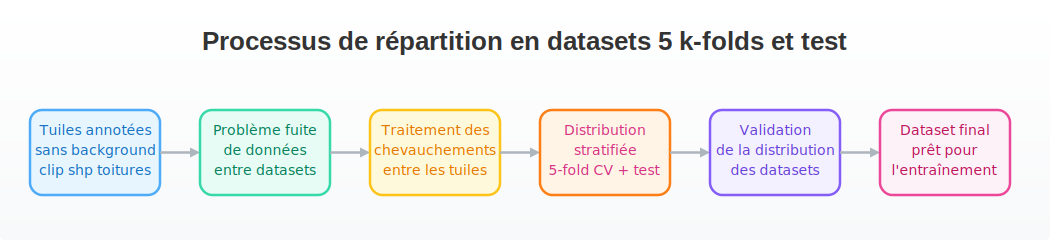

High-resolution PNG saved to data/notebook_06/graphics/06c_10_step0_overview.png (DPI: 2400, Scale: 4.0x)


In [9]:
svg_analyse="""
<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 1050 240" width="1050" height="240">
  <!-- Background with subtle gradient -->
  <defs>
    <linearGradient id="backgroundGradient" x1="0%" y1="0%" x2="0%" y2="100%">
      <stop offset="0%" style="stop-color:#ffffff;stop-opacity:1" />
      <stop offset="100%" style="stop-color:#f8f9fa;stop-opacity:1" />
    </linearGradient>
  </defs>
  <rect width="1050" height="240" fill="url(#backgroundGradient)" rx="5" />
  
  <!-- Title with improved typography and more top space -->
  <text x="525" y="50" font-size="26" font-weight="bold" text-anchor="middle" fill="#333333" font-family="Arial, Helvetica, sans-serif">
    Processus de répartition en datasets 5 k-folds et test
  </text>
  
  <!-- Process Flow with improved spacing -->
  <g transform="translate(30, 110)">
    <!-- Process Boxes with enhanced styling -->
    <g>
      <!-- Raw Tiles - Light Blue -->
      <rect x="0" y="0" width="130" height="85" fill="#e7f5ff" stroke="#4dabf7" stroke-width="2.5" rx="12" filter="drop-shadow(0px 2px 3px rgba(0,0,0,0.1))" />
      <text x="65" y="25" text-anchor="middle" font-size="14" fill="#1971c2">Tuiles annotées</text>
      <text x="65" y="45" text-anchor="middle" font-size="14"  fill="#1971c2">sans background</text>
      <text x="65" y="65" text-anchor="middle" font-size="14"  fill="#1971c2">clip shp toitures</text>
      
      <!-- Arrow with improved styling -->
      <line x1="130" y1="42.5" x2="160" y2="42.5" stroke="#adb5bd" stroke-width="2.5" />
      <polygon points="160,37.5 170,42.5 160,47.5" fill="#adb5bd" />
      
      <!-- Overlap Detection - Light Green -->
      <rect x="170" y="0" width="130" height="85" fill="#e6fcf5" stroke="#38d9a9" stroke-width="2.5" rx="12" filter="drop-shadow(0px 2px 3px rgba(0,0,0,0.1))" />
      <text x="235" y="25" text-anchor="middle" font-size="14" fill="#087f5b">Problème fuite</text>
      <text x="235" y="45" text-anchor="middle" font-size="14" fill="#087f5b">de données</text>
      <text x="235" y="65" text-anchor="middle" font-size="14" fill="#087f5b">entre datasets</text>

      <!-- Arrow with improved styling -->
      <line x1="300" y1="42.5" x2="330" y2="42.5" stroke="#adb5bd" stroke-width="2.5" />
      <polygon points="330,37.5 340,42.5 330,47.5" fill="#adb5bd" />
      
      <!-- Component Grouping - Light Yellow -->
      <rect x="340" y="0" width="130" height="85" fill="#fff9db" stroke="#fcc419" stroke-width="2.5" rx="12" filter="drop-shadow(0px 2px 3px rgba(0,0,0,0.1))" />
      <text x="405" y="25" text-anchor="middle" font-size="14" fill="#e67700">Traitement des</text>
      <text x="405" y="45" text-anchor="middle" font-size="14" fill="#e67700">chevauchements</text>
      <text x="405" y="65" text-anchor="middle" font-size="14" fill="#e67700">entre les tuiles</text>
      
      <!-- Arrow with improved styling -->
      <line x1="470" y1="42.5" x2="500" y2="42.5" stroke="#adb5bd" stroke-width="2.5" />
      <polygon points="500,37.5 510,42.5 500,47.5" fill="#adb5bd" />
      
      <!-- Stratified Distribution - Light Orange -->
      <rect x="510" y="0" width="130" height="85" fill="#fff4e6" stroke="#fd7e14" stroke-width="2.5" rx="12" filter="drop-shadow(0px 2px 3px rgba(0,0,0,0.1))" />
      <text x="575" y="25" text-anchor="middle" font-size="14" fill="#d63384">Distribution</text>
      <text x="575" y="45" text-anchor="middle" font-size="14" fill="#d63384">stratifiée</text>
      <text x="575" y="65" text-anchor="middle" font-size="14" fill="#d63384">5-fold CV + test</text>
      
      <!-- Arrow with improved styling -->
      <line x1="640" y1="42.5" x2="670" y2="42.5" stroke="#adb5bd" stroke-width="2.5" />
      <polygon points="670,37.5 680,42.5 670,47.5" fill="#adb5bd" />
      
      <!-- Validation - Light Purple -->
      <rect x="680" y="0" width="130" height="85" fill="#f3f0ff" stroke="#845ef7" stroke-width="2.5" rx="12" filter="drop-shadow(0px 2px 3px rgba(0,0,0,0.1))" />
      <text x="745" y="25" text-anchor="middle" font-size="14" fill="#6741d9">Validation</text>
      <text x="745" y="45" text-anchor="middle" font-size="14" fill="#6741d9">de la distribution</text>
      <text x="745" y="65" text-anchor="middle" font-size="14" fill="#6741d9">des datasets</text>
      
      <!-- Arrow with improved styling -->
      <line x1="810" y1="42.5" x2="840" y2="42.5" stroke="#adb5bd" stroke-width="2.5" />
      <polygon points="840,37.5 850,42.5 840,47.5" fill="#adb5bd" />
      
      <!-- Final Step - Light Pink -->
      <rect x="850" y="0" width="130" height="85" fill="#fdf2f8" stroke="#ec4899" stroke-width="2.5" rx="12" filter="drop-shadow(0px 2px 3px rgba(0,0,0,0.1))" />
      <text x="915" y="25" text-anchor="middle" font-size="14" fill="#be185d">Dataset final</text>
      <text x="915" y="45" text-anchor="middle" font-size="14" fill="#be185d">prêt pour</text>
      <text x="915" y="65" text-anchor="middle" font-size="14" fill="#be185d">l'entraînement</text>
    </g>
  </g>
</svg>
"""

save_svg_as_png(svg_analyse, "data/notebook_06/graphics/06c_10_step0_overview.png")

### Problème fuite de données

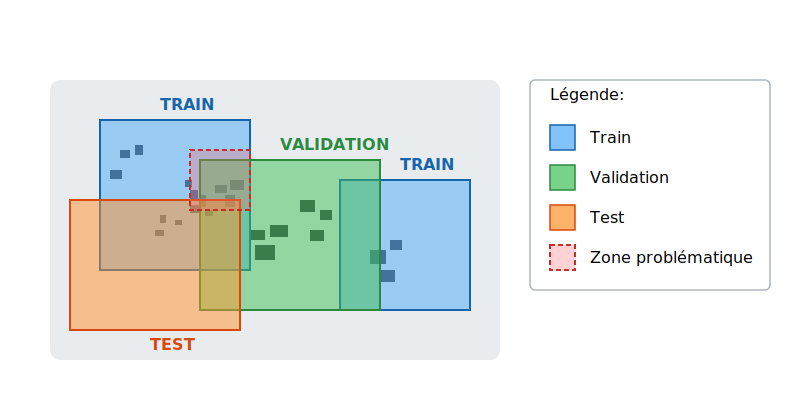

High-resolution PNG saved to data/notebook_06/graphics/06c_10_step1_data_leakage.png (DPI: 2400, Scale: 4.0x)


In [10]:
svg_analyse="""
<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 400" width="800" height="400">
  <!-- Background -->
  <rect width="800" height="400" fill="transparent" />
  
  <!-- Map Area with Overlapping Tiles - simplified background -->
  <rect x="50" y="80" width="450" height="280" fill="#e9ecef" rx="10" />
  
  <!-- Buildings in the area (small rectangles to represent buildings) -->
  <g>
    <!-- Urban core buildings -->
    <rect x="190" y="190" width="8" height="10" fill="#343a40" />
    <rect x="200" y="195" width="6" height="12" fill="#343a40" />
    <rect x="190" y="205" width="10" height="8" fill="#343a40" />
    <rect x="205" y="210" width="8" height="6" fill="#343a40" />
    <rect x="185" y="180" width="7" height="7" fill="#343a40" />

    <!-- Business district buildings -->
    <rect x="215" y="185" width="12" height="8" fill="#343a40" />
    <rect x="230" y="180" width="14" height="10" fill="#343a40" />
    <rect x="225" y="195" width="10" height="12" fill="#343a40" />
    
    <!-- Residential area buildings -->
    <rect x="160" y="215" width="6" height="8" fill="#343a40" />
    <rect x="175" y="220" width="7" height="5" fill="#343a40" />
    <rect x="155" y="230" width="9" height="6" fill="#343a40" />
    
    <!-- Industrial buildings -->
    <rect x="250" y="230" width="15" height="10" fill="#343a40" />
    <rect x="270" y="225" width="18" height="12" fill="#343a40" />
    <rect x="255" y="245" width="20" height="15" fill="#343a40" />
    
    <!-- Additional buildings across the map -->
    <rect x="120" y="150" width="10" height="8" fill="#343a40" />
    <rect x="135" y="145" width="8" height="10" fill="#343a40" />
    <rect x="110" y="170" width="12" height="9" fill="#343a40" />
    
    <rect x="300" y="200" width="15" height="12" fill="#343a40" />
    <rect x="320" y="210" width="12" height="10" fill="#343a40" />
    <rect x="310" y="230" width="14" height="11" fill="#343a40" />
    
    <rect x="370" y="250" width="16" height="14" fill="#343a40" />
    <rect x="390" y="240" width="12" height="10" fill="#343a40" />
    <rect x="380" y="270" width="15" height="12" fill="#343a40" />
  </g>
  
  <!-- Randomly Split Tiles with Better Visual Separation -->
  <g>
    <!-- Train Tiles (Blue) - Semi-transparent to see buildings underneath -->
    <rect x="100" y="120" width="150" height="150" fill="#4dabf7" fill-opacity="0.5" stroke="#1864ab" stroke-width="2" />
    <rect x="340" y="180" width="130" height="130" fill="#4dabf7" fill-opacity="0.5" stroke="#1864ab" stroke-width="2" />
    
    <!-- Validation Tiles (Green) -->
    <rect x="200" y="160" width="180" height="150" fill="#40c057" fill-opacity="0.5" stroke="#2b8a3e" stroke-width="2" />
    
    <!-- Test Tiles (Orange) -->
    <rect x="70" y="200" width="170" height="130" fill="#ff922b" fill-opacity="0.5" stroke="#d9480f" stroke-width="2" />
  </g>
  
  <!-- MAJOR Data Leakage Zone Highlight with enhanced visibility (but without text/arrows) -->
  <rect x="190" y="150" width="60" height="60" fill="#ff6b6b" fill-opacity="0.3" stroke="#c92a2a" stroke-width="2" stroke-dasharray="5 3" />
  
  <!-- Dataset labels -->
  <text x="160" y="110" font-size="16" font-weight="bold" fill="#1864ab">TRAIN</text>
  <text x="280" y="150" font-size="16" font-weight="bold" fill="#2b8a3e">VALIDATION</text>
  <text x="150" y="350" font-size="16" font-weight="bold" fill="#d9480f">TEST</text>
  <text x="400" y="170" font-size="16" font-weight="bold" fill="#1864ab">TRAIN</text>
  
  <!-- Legend Box - improved width -->
  <rect x="530" y="80" width="240" height="210" fill="white" stroke="#adb5bd" stroke-width="1.5" rx="5" />
  
  <!-- Legend - improved spacing -->
  <g transform="translate(550, 100)">
    <text x="0" y="0" font-size="16">Légende:</text>
    
    <rect x="0" y="25" width="25" height="25" fill="#4dabf7" fill-opacity="0.7" stroke="#1864ab" stroke-width="1.5" />
    <text x="40" y="43" font-size="16">Train</text>
    
    <rect x="0" y="65" width="25" height="25" fill="#40c057" fill-opacity="0.7" stroke="#2b8a3e" stroke-width="1.5" />
    <text x="40" y="83" font-size="16">Validation</text>
    
    <rect x="0" y="105" width="25" height="25" fill="#ff922b" fill-opacity="0.7" stroke="#d9480f" stroke-width="1.5" />
    <text x="40" y="123" font-size="16">Test</text>
    
    <rect x="0" y="145" width="25" height="25" fill="#ff6b6b" fill-opacity="0.3" stroke="#c92a2a" stroke-width="2" stroke-dasharray="5 3" />
    <text x="40" y="163" font-size="16">Zone problématique</text>
  </g>
</svg>
"""

save_svg_as_png(svg_analyse, "data/notebook_06/graphics/06c_10_step1_data_leakage.png")


### Traitement des chevauchements entre tuiles

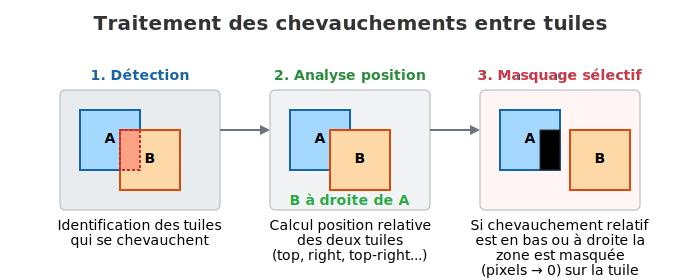

High-resolution PNG saved to data/notebook_06/graphics/06c_10_step2_selective_overlap_masking.png (DPI: 2400, Scale: 4.0x)


In [11]:
svg_analyse="""
<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 700 280" width="700" height="280">
  <!-- Background -->
  <rect width="700" height="280" fill="transparent" />
  
  <!-- Title -->
  <text x="350" y="30" font-size="20" font-weight="bold" text-anchor="middle" fill="#333">
    Traitement des chevauchements entre tuiles
  </text>
  
  <!-- Step 1: Detection -->
  <g transform="translate(60, 70)">
    <text x="80" y="10" font-size="14" font-weight="bold" text-anchor="middle" fill="#1864ab">1. Détection</text>
    
    <!-- Simple tile overlap visualization -->
    <rect x="0" y="20" width="160" height="120" fill="#e9ecef" rx="5" stroke="#adb5bd" stroke-width="1" />
    
    <!-- Two overlapping tiles -->
    <rect x="20" y="40" width="60" height="60" fill="#a5d8ff" stroke="#1864ab" stroke-width="2" />
    <text x="50" y="73" font-size="14" text-anchor="middle" font-weight="bold">A</text>
    
    <rect x="60" y="60" width="60" height="60" fill="#ffd8a8" stroke="#d9480f" stroke-width="2" />
    <text x="90" y="93" font-size="14" text-anchor="middle" font-weight="bold">B</text>
    
    <!-- Overlap zone -->
    <rect x="60" y="60" width="20" height="40" fill="#fa5252" fill-opacity="0.4" stroke="#c92a2a" stroke-width="2" stroke-dasharray="3 2" />
    
    <text x="80" y="160" font-size="14" text-anchor="middle">Identification des tuiles</text>
    <text x="80" y="175" font-size="14" text-anchor="middle">qui se chevauchent</text>
    <text x="80" y="190" font-size="14" text-anchor="middle"></text>
  </g>
  
  <!-- Arrow -->
  <g transform="translate(220, 130)">
    <line x1="0" y1="0" x2="40" y2="0" stroke="#6c757d" stroke-width="2" />
    <polygon points="40,-5 50,0 40,5" fill="#6c757d" />
  </g>
  
  <!-- Step 2: Position Analysis -->
  <g transform="translate(270, 70)">
    <text x="80" y="10" font-size="14" font-weight="bold" text-anchor="middle" fill="#2b8a3e">2. Analyse position</text>
    
    <rect x="0" y="20" width="160" height="120" fill="#f1f3f5" rx="5" stroke="#adb5bd" stroke-width="1" />
    
    <!-- Same tiles with position indicator -->
    <rect x="20" y="40" width="60" height="60" fill="#a5d8ff" stroke="#1864ab" stroke-width="2" />
    <text x="50" y="73" font-size="14" text-anchor="middle" font-weight="bold">A</text>
    
    <rect x="60" y="60" width="60" height="60" fill="#ffd8a8" stroke="#d9480f" stroke-width="2" />
    <text x="90" y="93" font-size="14" text-anchor="middle" font-weight="bold">B</text>
    
   
    <!-- Arrow marker definition -->
    <defs>
      <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="9" refY="3.5" orient="auto">
        <polygon points="0 0, 10 3.5, 0 7" fill="#28a745" />
      </marker>
    </defs>
    
    <text x="80" y="135" font-size="14" text-anchor="middle" fill="#28a745" font-weight="bold">B à droite de A</text>
    
    <text x="80" y="160" font-size="14" text-anchor="middle">Calcul position relative</text>
    <text x="80" y="175" font-size="14" text-anchor="middle">des deux tuiles</text>
    <text x="80" y="190" font-size="14" text-anchor="middle">(top, right, top-right...)</text>
  </g>
  
  <!-- Arrow -->
  <g transform="translate(430, 130)">
    <line x1="0" y1="0" x2="40" y2="0" stroke="#6c757d" stroke-width="2" />
    <polygon points="40,-5 50,0 40,5" fill="#6c757d" />
  </g>
  
  <!-- Step 3: Selective Masking -->
  <g transform="translate(480, 70)">
    <text x="80" y="10" font-size="14" font-weight="bold" text-anchor="middle" fill="#dc3545">3. Masquage sélectif</text>
    
    <rect x="0" y="20" width="160" height="120" fill="#fff5f5" rx="5" stroke="#adb5bd" stroke-width="1" />
    
    <!-- Result after masking -->
    <rect x="20" y="40" width="60" height="60" fill="#a5d8ff" stroke="#1864ab" stroke-width="2" />
    <text x="50" y="73" font-size="14" text-anchor="middle" font-weight="bold">A</text>
    
    <!-- Masked area (black) -->
    <rect x="60" y="60" width="20" height="40" fill="#000000" stroke="#333" stroke-width="1" />
    
    <!-- Remaining part of B -->
    <rect x="90" y="60" width="60" height="60" fill="#ffd8a8" stroke="#d9480f" stroke-width="2" />
    <text x="120" y="93" font-size="14" text-anchor="middle" font-weight="bold">B</text>
    
    <text x="80" y="160" font-size="14" text-anchor="middle">Si chevauchement relatif</text>
    <text x="80" y="175" font-size="14" text-anchor="middle">est en bas ou à droite la</text>
    <text x="80" y="190" font-size="14" text-anchor="middle">zone est masquée</text>
    <text x="80" y="205" font-size="14" text-anchor="middle">(pixels → 0) sur la tuile</text>
  </g>
 

</svg>
"""

save_svg_as_png(svg_analyse, "data/notebook_06/graphics/06c_10_step2_selective_overlap_masking.png")

### Distribution stratifiée des tuiles en 5 k-fold + test

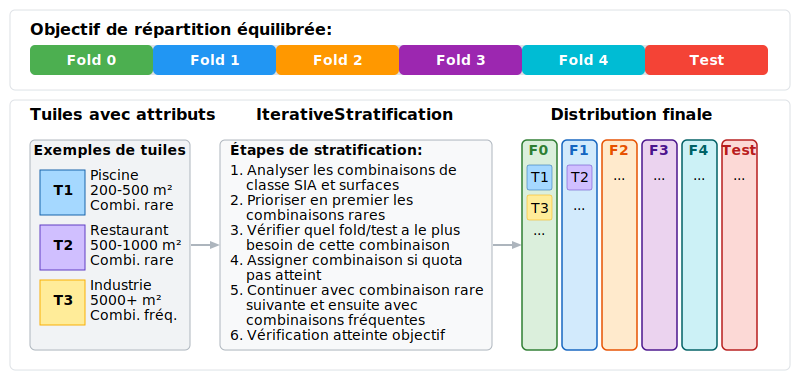

High-resolution PNG saved to data/notebook_06/graphics/06c_10_step3_distribution_datasets.png (DPI: 2400, Scale: 4.0x)


In [12]:
svg_analyse="""
<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 380" width="800" height="380">
  <!-- Background -->
  <rect width="800" height="380" fill="transparent" />
  
  <!-- Target Distribution Panel -->
  <g transform="translate(10, 10)">
    <rect x="0" y="0" width="780" height="80" fill="white" stroke="#dee2e6" stroke-width="1" rx="5" />
    <text x="20" y="25" font-size="16" font-weight="bold">Objectif de répartition équilibrée:</text>
    
    <!-- Target Distribution Bar for K-Fold -->
    <rect x="20" y="35" width="700" height="30" fill="#dee2e6" rx="5" />
    <!-- Each fold gets ~16.7% (5 folds = 83.3% total), test gets 16.7% -->
    <rect x="20" y="35" width="123" height="30" fill="#4CAF50" rx="5" />
    <rect x="143" y="35" width="123" height="30" fill="#2196F3" rx="5" />
    <rect x="266" y="35" width="123" height="30" fill="#FF9800" rx="5" />
    <rect x="389" y="35" width="123" height="30" fill="#9C27B0" rx="5" />
    <rect x="512" y="35" width="123" height="30" fill="#00BCD4" rx="5" />
    <rect x="635" y="35" width="123" height="30" fill="#F44336" rx="5" />
    
    <!-- K-Fold Labels -->
    <text x="82" y="55" font-size="14" fill="white" text-anchor="middle" font-weight="bold">Fold 0</text>
    <text x="205" y="55" font-size="14" fill="white" text-anchor="middle" font-weight="bold">Fold 1</text>
    <text x="328" y="55" font-size="14" fill="white" text-anchor="middle" font-weight="bold">Fold 2</text>
    <text x="451" y="55" font-size="14" fill="white" text-anchor="middle" font-weight="bold">Fold 3</text>
    <text x="574" y="55" font-size="14" fill="white" text-anchor="middle" font-weight="bold">Fold 4</text>
    <text x="697" y="55" font-size="14" fill="white" text-anchor="middle" font-weight="bold">Test</text>
  </g>
  
  <!-- Main Algorithm Visualization -->
  <g transform="translate(10, 100)">
    <rect x="0" y="0" width="780" height="270" fill="white" stroke="#dee2e6" stroke-width="1" rx="5" />
    
    <!-- Left Panel: Input Data -->
    <g transform="translate(20, 20)">
      <text x="0" y="0" font-size="16" font-weight="bold">Tuiles avec attributs</text>
      
      <!-- Tile Examples with Attributes -->
      <g transform="translate(0, 20)">
        <!-- Sample Tiles -->
        <rect x="0" y="0" width="160" height="210" fill="#f1f3f5" stroke="#adb5bd" stroke-width="1" rx="5" />
        <text x="80" y="15" font-size="14" text-anchor="middle" font-weight="bold">Exemples de tuiles</text>
        
        <!-- Tile 1 -->
        <rect x="10" y="30" width="45" height="45" fill="#a5d8ff" stroke="#1864ab" stroke-width="1" />
        <text x="33" y="55" font-size="14" text-anchor="middle" font-weight="bold">T1</text>
        <text x="60" y="40" font-size="14">Piscine</text>
        <text x="60" y="55" font-size="14">200-500 m²</text>
        <text x="60" y="70" font-size="14">Combi. rare</text>
        
        <!-- Tile 2 -->
        <rect x="10" y="85" width="45" height="45" fill="#d0bfff" stroke="#5f3dc4" stroke-width="1" />
        <text x="33" y="110" font-size="14" text-anchor="middle" font-weight="bold">T2</text>
        <text x="60" y="95" font-size="14">Restaurant</text>
        <text x="60" y="110" font-size="14">500-1000 m²</text>
        <text x="60" y="125" font-size="14">Combi. rare</text>
        
        <!-- Tile 3 -->
        <rect x="10" y="140" width="45" height="45" fill="#ffec99" stroke="#fab005" stroke-width="1" />
        <text x="33" y="165" font-size="14" text-anchor="middle" font-weight="bold">T3</text>
        <text x="60" y="150" font-size="14">Industrie</text>
        <text x="60" y="165" font-size="14">5000+ m²</text>
        <text x="60" y="180" font-size="14">Combi. fréq.</text>

      </g>
    </g>

    <!-- ARROW 1: From Input to Algorithm -->
    <g transform="translate(168, 145)">
      <line x1="13" y1="0" x2="32" y2="0" stroke="#adb5bd" stroke-width="2" />
      <polygon points="32,-4 42,0 32,4" fill="#adb5bd" />
    </g>

    <!-- Center Panel: IterativeStratification Algorithm -->
    <g transform="translate(210, 20)">
      <text x="135" y="0" font-size="16" text-anchor="middle" font-weight="bold">IterativeStratification</text>
      
      <rect x="0" y="20" width="272" height="210" fill="#f8f9fa" stroke="#adb5bd" stroke-width="1" rx="5" />
      
      <!-- Algorithm Steps -->
      <text x="10" y="35" font-size="14" font-weight="bold">Étapes de stratification:</text>
      
      <text x="10" y="55" font-size="14">1. Analyser les combinaisons de</text>
      <text x="26" y="70" font-size="14">classe SIA et surfaces</text>
      <text x="10" y="85" font-size="14">2. Prioriser en premier les</text>
      <text x="26" y="100" font-size="14">combinaisons rares</text>
      <text x="10" y="115" font-size="14">3. Vérifier quel fold/test a le plus</text>
      <text x="26" y="130" font-size="14">besoin de cette combinaison</text>
      <text x="10" y="145" font-size="14">4. Assigner combinaison si quota</text>
      <text x="26" y="160" font-size="14">pas atteint</text>
      <text x="10" y="175" font-size="14">5. Continuer avec combinaison rare</text>
      <text x="26" y="190" font-size="14">suivante et ensuite avec</text>
      <text x="26" y="205" font-size="14">combinaisons fréquentes</text>
      <text x="10" y="220" font-size="14">6. Vérification atteinte objectif</text>
      

    </g>

    <!-- ARROW 2: From Algorithm to Result -->
    <g transform="translate(470, 145)">
      <line x1="13" y1="0" x2="32" y2="0" stroke="#adb5bd" stroke-width="2" />
      <polygon points="32,-4 42,0 32,4" fill="#adb5bd" />
    </g>

    <!-- Right Panel: Result -->
    <g transform="translate(502, 20)">
      <text x="120" y="0" font-size="16" font-weight="bold" text-anchor="middle">Distribution finale</text>
      
      <!-- Final Dataset Columns -->
      <g transform="translate(10, 20)">
        <!-- K-Fold datasets -->
        <rect x="0" y="0" width="35" height="210" fill="#4CAF50" fill-opacity="0.2" stroke="#2E7D32" stroke-width="1.5" rx="5" />
        <text x="17" y="15" font-size="14" text-anchor="middle" font-weight="bold" fill="#2E7D32">F0</text>
        
        <rect x="40" y="0" width="35" height="210" fill="#2196F3" fill-opacity="0.2" stroke="#1565C0" stroke-width="1.5" rx="5" />
        <text x="57" y="15" font-size="14" text-anchor="middle" font-weight="bold" fill="#1565C0">F1</text>
        
        <rect x="80" y="0" width="35" height="210" fill="#FF9800" fill-opacity="0.2" stroke="#E65100" stroke-width="1.5" rx="5" />
        <text x="97" y="15" font-size="14" text-anchor="middle" font-weight="bold" fill="#E65100">F2</text>
        
        <rect x="120" y="0" width="35" height="210" fill="#9C27B0" fill-opacity="0.2" stroke="#4A148C" stroke-width="1.5" rx="5" />
        <text x="137" y="15" font-size="14" text-anchor="middle" font-weight="bold" fill="#4A148C">F3</text>
        
        <rect x="160" y="0" width="35" height="210" fill="#00BCD4" fill-opacity="0.2" stroke="#006064" stroke-width="1.5" rx="5" />
        <text x="177" y="15" font-size="14" text-anchor="middle" font-weight="bold" fill="#006064">F4</text>
        
        <!-- Test Dataset -->
        <rect x="200" y="0" width="35" height="210" fill="#F44336" fill-opacity="0.2" stroke="#B71C1C" stroke-width="1.5" rx="5" />
        <text x="217" y="15" font-size="14" text-anchor="middle" font-weight="bold" fill="#B71C1C">Test</text>
        
        <!-- Sample tiles in each dataset with balanced distribution -->
        <!-- Fold 0 -->
        <rect x="5" y="25" width="25" height="25" fill="#a5d8ff" stroke="#1864ab" stroke-width="0.5" rx="2" />
        <text x="17" y="42" font-size="14" text-anchor="middle">T1</text>
        <rect x="45" y="25" width="25" height="25" fill="#d0bfff" stroke="#5f3dc4" stroke-width="0.5" rx="2" />
        <text x="57" y="42" font-size="14" text-anchor="middle">T2</text>
        <rect x="5" y="55" width="25" height="25" fill="#ffec99" stroke="#fab005" stroke-width="0.5" rx="2" />
        <text x="17" y="73" font-size="14" text-anchor="middle">T3</text>
        
        <!-- Similar pattern for other folds (simplified) -->
        <text x="17" y="95" font-size="14" text-anchor="middle">...</text>
        <text x="57" y="70" font-size="14" text-anchor="middle">...</text>
        <text x="97" y="40" font-size="14" text-anchor="middle">...</text>
        <text x="137" y="40" font-size="14" text-anchor="middle">...</text>
        <text x="177" y="40" font-size="14" text-anchor="middle">...</text>
        <text x="217" y="40" font-size="14" text-anchor="middle">...</text>
      </g>
    </g>
  </g>

</svg>
"""

save_svg_as_png(svg_analyse, "data/notebook_06/graphics/06c_10_step3_distribution_datasets.png")

### Validation

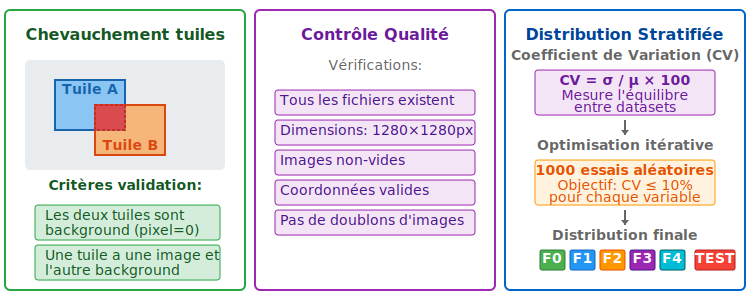

High-resolution PNG saved to data/notebook_06/graphics/ch3_postprocessing_dataset_07_validation.png (DPI: 2400, Scale: 4.0x)


: 

In [ ]:
svg_analyse = """
<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 750 300" width="750" height="300">
  <!-- Background -->
  <rect width="750" height="300" fill="transparent" />
  
  <!-- Data Leakage Prevention Panel -->
  <g transform="translate(5, 10)">
    <rect x="0" y="0" width="240" height="280" fill="white" stroke="#28a745" stroke-width="2" rx="5" />
    <text x="120" y="30" font-size="16" font-weight="bold" text-anchor="middle" fill="#155724">Chevauchement tuiles</text>
    
    <!-- Overlapping tiles visualization -->
    <rect x="20" y="50" width="200" height="110" fill="#e9ecef" rx="5" />
    
    <!-- Two overlapping tiles -->
    <g transform="translate(50, 70)">
      <!-- Tile A -->
      <rect x="0" y="0" width="70" height="50" fill="#4dabf7" fill-opacity="0.6" stroke="#1864ab" stroke-width="2" />
      <text x="35" y="14" font-size="14" font-weight="bold" fill="#1864ab" text-anchor="middle">Tuile A</text>
      
      <!-- Tile B overlapping -->
      <rect x="40" y="25" width="70" height="50" fill="#ff922b" fill-opacity="0.6" stroke="#d9480f" stroke-width="2" />
      <text x="75" y="70" font-size="14" font-weight="bold" fill="#d9480f" text-anchor="middle">Tuile B</text>
    
    <!-- Overlap zone highlight -->
      <rect x="40" y="25" width="30" height="25" fill="#dc3545" fill-opacity="0.8" stroke="#c92a2a" stroke-width="2" stroke-dasharray="3,2" />  
    </g>
    
    <!-- Verification process -->
    <g transform="translate(20, 180)">
      <text x="100" y="0" font-size="14" font-weight="bold" text-anchor="middle" fill="#155724">Critères validation:</text>
      
      <!-- Check 1 -->
      <rect x="10" y="15" width="185" height="35" fill="#d4edda" stroke="#28a745" stroke-width="1" rx="3" />
      <text x="20" y="30" font-size="14" fill="#155724">Les deux tuiles sont</text>
      <text x="20" y="45" font-size="14" fill="#155724">background (pixel=0)</text>
      
      <!-- Check 2 -->
      <rect x="10" y="55" width="185" height="35" fill="#d4edda" stroke="#28a745" stroke-width="1" rx="3" />
      <text x="20" y="70" font-size="14" fill="#155724">Une tuile a une image et</text>
      <text x="20" y="85" font-size="14" fill="#155724">l'autre background</text>
      

    </g>
  </g>
  
  <!-- Stratified Distribution Panel -->
  <g transform="translate(505, 10)">
    <rect x="0" y="0" width="240" height="280" fill="white" stroke="#0066cc" stroke-width="2" rx="5" />
    <text x="120" y="30" font-size="16" font-weight="bold" text-anchor="middle" fill="#004499">Distribution Stratifiée</text>
    
    <!-- Step 1: CV Definition -->
    <g transform="translate(20, 50)">
      <text x="100" y="0" font-size="14" font-weight="bold" text-anchor="middle" fill="#666">Coefficient de Variation (CV)</text>
      
      <!-- CV Formula -->
      <rect x="10" y="10" width="180" height="45" fill="#f3e5f5" stroke="#9c27b0" stroke-width="1" rx="3" />
      <text x="100" y="25" font-size="14" text-anchor="middle" fill="#6a1b9a" font-weight="bold">CV = σ / μ × 100</text>
      <text x="100" y="40" font-size="14" text-anchor="middle" fill="#6a1b9a">Mesure l'équilibre</text>
      <text x="100" y="52" font-size="14" text-anchor="middle" fill="#6a1b9a">entre datasets</text>
    </g>
    
    <!-- Arrow down -->
    <g transform="translate(120, 110)">
      <line x1="0" y1="0" x2="0" y2="15" stroke="#666" stroke-width="2" />
      <polygon points="0,15 -4,10 4,10" fill="#666" />
    </g>
    
    <!-- Step 2: Optimization Process -->
    <g transform="translate(20, 140)">
      <text x="100" y="0" font-size="14" font-weight="bold" text-anchor="middle" fill="#666">Optimisation itérative</text>
      
      <rect x="10" y="10" width="180" height="45" fill="#fff3e0" stroke="#ff9800" stroke-width="1" rx="3" />
      <text x="100" y="25" font-size="14" text-anchor="middle" fill="#e65100" font-weight="bold">1000 essais aléatoires</text>
      <text x="100" y="40" font-size="14" text-anchor="middle" fill="#e65100">Objectif: CV ≤ 10%</text>
      <text x="100" y="52" font-size="14" text-anchor="middle" fill="#e65100">pour chaque variable</text>
    </g>
    
    <!-- Arrow down -->
    <g transform="translate(120, 200)">
      <line x1="0" y1="0" x2="0" y2="15" stroke="#666" stroke-width="2" />
      <polygon points="0,15 -4,10 4,10" fill="#666" />
    </g> 
    
    <!-- Step 3: Final Distribution -->
    <g transform="translate(20, 225)">
      <text x="100" y="5" font-size="14" font-weight="bold" text-anchor="middle" fill="#666">Distribution finale</text>
      
      <!-- Visual representation of 5 folds + test -->
      <g transform="translate(15, 15)">
        <!-- 5 CV folds -->
        <rect x="0" y="0" width="25" height="20" fill="#4CAF50" stroke="#2E7D32" rx="2" />
        <text x="12.5" y="13" font-size="14" fill="white" text-anchor="middle" font-weight="bold">F0</text>
        
        <rect x="30" y="0" width="25" height="20" fill="#2196F3" stroke="#1565C0" rx="2" />
        <text x="42.5" y="13" font-size="14" fill="white" text-anchor="middle" font-weight="bold">F1</text>
        
        <rect x="60" y="0" width="25" height="20" fill="#FF9800" stroke="#E65100" rx="2" />
        <text x="72.5" y="13" font-size="14" fill="white" text-anchor="middle" font-weight="bold">F2</text>
        
        <rect x="90" y="0" width="25" height="20" fill="#9C27B0" stroke="#4A148C" rx="2" />
        <text x="102.5" y="13" font-size="14" fill="white" text-anchor="middle" font-weight="bold">F3</text>
        
        <rect x="120" y="0" width="25" height="20" fill="#00BCD4" stroke="#006064" rx="2" />
        <text x="132.5" y="13" font-size="14" fill="white" text-anchor="middle" font-weight="bold">F4</text>
        
        <!-- Test set -->
        <rect x="155" y="0" width="40" height="20" fill="#F44336" stroke="#B71C1C" rx="2" />
        <text x="175" y="13" font-size="14" fill="white" text-anchor="middle" font-weight="bold">TEST</text>

      </g>
    </g>
  </g>
  
  <!-- Technical Validation Panel -->
  <g transform="translate(255, 10)">
    <rect x="0" y="0" width="240" height="280" fill="white" stroke="#9c27b0" stroke-width="2" rx="5" />
    
    <!-- Header -->
    <text x="120" y="30" font-size="16" font-weight="bold" text-anchor="middle" fill="#6a1b9a">Contrôle Qualité</text>
    
    <!-- Technical checks -->
    <g transform="translate(20, 60)">
      <text x="100" y="0" font-size="14" text-anchor="middle" fill="#666">Vérifications:</text>
      
      <!-- File existence check -->
      <g transform="translate(0, 20)">
        <rect x="0" y="0" width="200" height="25" fill="#f3e5f5" stroke="#9c27b0" stroke-width="1" rx="3" />
        <text x="5" y="15" font-size="14" fill="#4a148c">Tous les fichiers existent</text>
      </g>
      
      <!-- Dimension check -->
      <g transform="translate(0, 50)">
        <rect x="0" y="0" width="200" height="25" fill="#f3e5f5" stroke="#9c27b0" stroke-width="1" rx="3" />
        <text x="5" y="15" font-size="14" fill="#4a148c">Dimensions: 1280×1280px</text>
      </g>
      
      <!-- Content check -->
      <g transform="translate(0, 80)">
        <rect x="0" y="0" width="200" height="25" fill="#f3e5f5" stroke="#9c27b0" stroke-width="1" rx="3" />
        <text x="5" y="15" font-size="14" fill="#4a148c">Images non-vides</text>
      </g>
      
      <!-- Geometry check -->
      <g transform="translate(0, 110)">
        <rect x="0" y="0" width="200" height="25" fill="#f3e5f5" stroke="#9c27b0" stroke-width="1" rx="3" />
        <text x="5" y="15" font-size="14" fill="#4a148c">Coordonnées valides</text>
      </g>
      
      <!-- Duplicate check -->
      <g transform="translate(0, 140)">
        <rect x="0" y="0" width="200" height="25" fill="#f3e5f5" stroke="#9c27b0" stroke-width="1" rx="3" />
        <text x="5" y="15" font-size="14" fill="#4a148c">Pas de doublons d'images</text>
      </g>
    </g>

  </g>
</svg>
"""

save_svg_as_png(svg_analyse, "data/notebook_06/graphics/ch3_postprocessing_dataset_07_validation.png")

## Map

### Avant

In [ ]:
def make_folium_heatmap(gdf):
    """
    Create an interactive Folium map with GeoTIFF tile boundaries, centroids, and a heatmap layer.

    Parameters:
        gdf (GeoDataFrame): GeoDataFrame containing tile geometries and metadata.

    Returns:
        folium.Map: Folium map object with tile boundaries, centroids, and heatmap.
    """
    # Convert geometries to WGS84 for compatibility with Folium
    gdf_wgs84 = gdf.to_crs(epsg=4326)

    # Calculate the centroid of all geometries for map centering
    centroid = union_all(gdf_wgs84.geometry).centroid

    # Initialize the Folium map centered on the dataset
    m = folium.Map(
        location=[centroid.y, centroid.x], 
        zoom_start=12,
        tiles='CartoDB positron',
        control_scale=True,
    )

    # Add GeoJSON layer with styled boundaries and tooltips
    folium.GeoJson(
        gdf_wgs84,
        name='GeoTIFF Tiles',
        tooltip=folium.GeoJsonTooltip(
            fields=['tile_path'],
            aliases=['Tile:'],
            sticky=True,
            labels=True,
            style='''
                background-color: rgba(255, 255, 255, 0.8);
                border: 1px solid #ccc;
                border-radius: 3px;
                box-shadow: 0 0 3px rgba(0,0,0,0.2);
                font-size: 12px;
                padding: 4px 8px;
            '''
        ),
        style_function=lambda x: {
            'fillColor': '#3388ff',
            'color': '#004da8',
            'weight': 2,
            'fillOpacity': 0.2,
            'dashArray': '3'
        },
        highlight_function=lambda x: {
            'fillColor': '#ff8800',
            'color': '#d35400',
            'weight': 3,
            'fillOpacity': 0.4
        }
    ).add_to(m)

    # Create a marker cluster for tile centroids
    marker_cluster = MarkerCluster(name="Tile Centers")
    m.add_child(marker_cluster)

    # Add a circle marker at each tile centroid with a popup
    for idx, row in gdf_wgs84.iterrows():
        tile_centroid = row.geometry.centroid
        popup_content = f"""
        <div style="font-family: Arial, sans-serif; max-width: 250px;">
            <h4 style="margin: 0 0 8px 0;">Tile {idx}</h4>
            <p style="margin: 0; font-size: 12px; color: #555;">
                <b>Path:</b> {os.path.basename(row['tile_path'])}<br>
                <b>Dimensions:</b> {row['image_width']}×{row['image_height']}px
            </p>
        </div>
        """
        folium.CircleMarker(
            location=[tile_centroid.y, tile_centroid.x],
            radius=4,
            popup=folium.Popup(popup_content, max_width=300),
            color='#1e88e5',
            fill=True,
            fill_color='#1e88e5',
            fill_opacity=0.7,
            weight=1
        ).add_to(marker_cluster)

    # Prepare data for the heatmap layer using tile centroids
    heat_data = [[point.y, point.x] for point in gdf_wgs84.geometry.centroid]

    # Add a heatmap layer to visualize tile density
    HeatMap(
        heat_data,
        name="Tile Density",
        radius=15,
        blur=10,
        gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}
    ).add_to(m)

    # Add a styled title to the map
    title_html = f'''
    <div style="
        position: absolute; 
        top: 10px; 
        left: 50%; 
        transform: translateX(-50%);
        z-index: 9999; 
        background-color: white; 
        padding: 8px 15px; 
        border-radius: 5px;
        box-shadow: 0 0 5px rgba(0,0,0,0.2);
        font-family: Arial, sans-serif; 
        font-size: 16px; 
        font-weight: bold; 
        text-align: center;
        pointer-events: none;">
        GeoTIFF Tiles Dataset - Geneva Region<br>
        <span style="display: block; font-size: 13px; font-weight: normal; text-align: center;">{len(gdf_wgs84)} tiles</span>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))

    # Add layer control for toggling map layers
    folium.LayerControl(
        position='topright',
        collapsed=False
    ).add_to(m)

    # Save the map to an HTML file
    path = Path(GRAPHICS_PATH) / "06c_11_map_avant_heatmap_tiles.html"
    m.save(path)

    return m

In [15]:
m = make_folium_heatmap(gdf_dataset_validation)
m

/tmp/ipykernel_3247976/2312059724.py:86: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  heat_data = [[point.y, point.x] for point in gdf_wgs84.geometry.centroid]


### Split

In [ ]:
# Convert GeoDataFrame to WGS84 (EPSG:4326) for folium compatibility
gdf_dataset_validation_wgs84 = gdf_dataset_validation_split.to_crs(epsg=4326)

# Calculate the centroid of all geometries for map centering
centroid = union_all(gdf_dataset_validation_wgs84.geometry).centroid

# Initialize Folium map centered on the calculated centroid
m = folium.Map(
    location=[centroid.y, centroid.x], 
    zoom_start=12,
    tiles='CartoDB positron',  # Light, clean background
    control_scale=True,
)

# Define color schemes for each fold and the test set
fold_colors = {
    0: {'fill': '#4CAF50', 'border': '#2E7D32', 'name': 'Fold 0'},      # Green
    1: {'fill': '#2196F3', 'border': '#1565C0', 'name': 'Fold 1'},      # Blue
    2: {'fill': '#FF9800', 'border': '#E65100', 'name': 'Fold 2'},      # Orange
    3: {'fill': '#9C27B0', 'border': '#4A148C', 'name': 'Fold 3'},      # Purple
    4: {'fill': '#00BCD4', 'border': '#006064', 'name': 'Fold 4'},      # Cyan
    5: {'fill': '#F44336', 'border': '#B71C1C', 'name': 'Test Set'}     # Red
}

# Create feature groups for each fold and the test set
feature_groups = {}
for dataset_id, colors in fold_colors.items():
    group_name = colors['name']
    feature_groups[dataset_id] = folium.FeatureGroup(name=group_name)
    m.add_child(feature_groups[dataset_id])

# Count the number of samples in each dataset
dataset_counts = gdf_dataset_validation_wgs84['dataset'].value_counts().sort_index()

# Function to add polygons and markers for each dataset to the map
def add_dataset_to_map(gdf, feature_group, colors, dataset_name, dataset_id):
    for idx, row in gdf.iterrows():
        tile_id = str(row.get('tile_id', idx))
        dominant_class = str(row.get('dominant_class', 'N/A'))
        intervalle_surface = str(row.get('area_bin', 'N/A'))
        
        # Tooltip for polygons
        tooltip_html = f"""
        <div style="font-family: Arial, sans-serif; font-size: 12px;">
            <b>{dataset_name} - Tile {tile_id}</b><br>
            Classe SIA dominante: {dominant_class}<br>
            Intervale surface: {intervalle_surface} m²<br>
            Dataset: {dataset_name}<br>
        </div>
        """
        
        # Add polygon with tooltip and style
        folium.GeoJson(
            data=row.geometry.__geo_interface__,
            tooltip=folium.Tooltip(tooltip_html),
            style_function=lambda x, colors=colors: {
                'fillColor': colors['fill'],
                'color': colors['border'],
                'weight': 2,
                'fillOpacity': 0.3,
                'dashArray': '3' if dataset_id < 5 else '0'
            },
            highlight_function=lambda x: {
                'fillColor': colors['fill'],
                'color': colors['border'],
                'weight': 3,
                'fillOpacity': 0.6,
                'dashArray': '0'
            }
        ).add_to(feature_group)
    
    # Add centroid markers for each tile
    for idx, row in gdf.iterrows():
        tile_centroid = row.geometry.centroid
        tile_id = str(row.get('tile_id', idx))
        dominant_class = str(row.get('dominant_class', 'N/A'))
        intervalle_surface = str(row.get('area_bin', 'N/A'))
        
        popup_content = f"""
        <div style="font-family: Arial, sans-serif; max-width: 300px;">
            <h4 style="margin: 0 0 8px 0; color: {colors['border']};">
                {dataset_name} - Tile {tile_id}
            </h4>
            <p style="margin: 0; font-size: 12px; color: #555;">
                <b>Classe SIA dominante:</b> {dominant_class}<br>
                <b>Intervale surface:</b> {intervalle_surface} m²<br>
                <b>Dataset:</b> {dataset_name}<br>
            </p>
        </div>
        """
        
        tooltip_content = f"{dataset_name} | {dominant_class} | {intervalle_surface} m²"
        marker_radius = 4 if dataset_id < 5 else 5
        
        folium.CircleMarker(
            location=[tile_centroid.y, tile_centroid.x],
            radius=marker_radius,
            popup=folium.Popup(popup_content, max_width=300),
            tooltip=tooltip_content,
            color=colors['border'],
            fill=True,
            fill_color=colors['fill'],
            fill_opacity=0.8 if dataset_id == 5 else 0.7,
            weight=2 if dataset_id == 5 else 1
        ).add_to(feature_group)

# Add each fold and the test set to the map
for dataset_id, colors in fold_colors.items():
    dataset_gdf = gdf_dataset_validation_wgs84[gdf_dataset_validation_wgs84['dataset'] == dataset_id]
    if len(dataset_gdf) > 0:
        add_dataset_to_map(dataset_gdf, feature_groups[dataset_id], colors, colors['name'], dataset_id)

# Create a density heatmap layer
heatmap_group = folium.FeatureGroup(name="Density Heatmap")

# Extract centroid coordinates for the heatmap
heat_data = [[point.y, point.x] for point in gdf_dataset_validation_wgs84.geometry.centroid]

# Add heatmap with a purple-to-pink gradient
HeatMap(
    heat_data,
    name="Density",
    radius=15,
    blur=10,
    max_zoom=13,
    gradient={
        0.2: '#9C27B0',
        0.4: '#673AB7',
        0.6: '#E91E63',
        0.8: '#F48FB1',
        1.0: '#FFCDD2'
    }
).add_to(heatmap_group)

m.add_child(heatmap_group)

# Calculate statistics for each dataset
total_samples = len(gdf_dataset_validation_wgs84)
dataset_stats = []

for dataset_id in sorted(dataset_counts.index):
    count = dataset_counts[dataset_id]
    percentage = count / total_samples * 100
    name = fold_colors[dataset_id]['name']
    dataset_stats.append({
        'id': dataset_id,
        'name': name,
        'count': count,
        'percentage': percentage,
        'colors': fold_colors[dataset_id]
    })

# Build legend for fold and test set distribution
legend_items = []
for stat in dataset_stats:
    legend_items.append(f'''
        <div style="display: flex; align-items: center; margin-bottom: 6px;">
            <span style="
                display: inline-block;
                width: 14px;
                height: 14px;
                margin-right: 8px;
                background-color: {stat['colors']['fill']};
                border: 1px solid {stat['colors']['border']};
                border-radius: 2px;
            "></span>
            <span>{stat['name']}: <b>{stat['count']}</b> tiles ({stat['percentage']:.1f}%)</span>
        </div>
    ''')

legend_html = f'''
<div style="
    position: fixed; 
    bottom: 20px; 
    left: 10px; 
    z-index: 1000; 
    background-color: white; 
    padding: 10px 15px; 
    border-radius: 5px;
    box-shadow: 0 0 5px rgba(0,0,0,0.2);
    font-family: Arial, sans-serif;
    font-size: 13px;
    line-height: 1.5;
    max-height: 400px;
    overflow-y: auto;
">
    <h4 style="margin: 0 0 10px 0; font-size: 14px;">K-Fold Cross-Validation Split</h4>
    <div>
        {''.join(legend_items)}
    </div>
    <div style="margin-top: 10px; padding-top: 8px; border-top: 1px solid #eee; font-size: 11px; color: #666;">
        Folds 0-4: Training/Validation<br>
        Fold 5: Final Test Set
    </div>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

# Add legend for the heatmap
heatmap_legend_html = '''
<div style="
    position: fixed; 
    bottom: 20px; 
    right: 10px; 
    z-index: 1000; 
    background-color: white; 
    padding: 10px 15px; 
    border-radius: 5px;
    box-shadow: 0 0 5px rgba(0,0,0,0.2);
    font-family: Arial, sans-serif;
    font-size: 13px;
    line-height: 1.5;
    max-width: 200px;
">
    <h4 style="margin: 0 0 10px 0; font-size: 14px;">Tile Density</h4>
    <div style="display: flex; height: 20px; margin-bottom: 5px;">
        <div style="flex-grow: 1; background: linear-gradient(to right, #9C27B0, #673AB7, #E91E63, #F48FB1, #FFCDD2);"></div>
    </div>
    <div style="display: flex; justify-content: space-between; font-size: 11px;">
        <span>Low</span>
        <span>High</span>
    </div>
</div>
'''

m.get_root().html.add_child(folium.Element(heatmap_legend_html))

# Prepare map title with k-fold and test set information
n_folds = len([d for d in dataset_counts.index if d < 5])
test_count = dataset_counts.get(5, 0) if 5 in dataset_counts.index else dataset_counts.max()

title_html = f'''
<div style="
    position: absolute; 
    top: 10px; 
    left: 50%; 
    transform: translateX(-50%);
    z-index: 9999; 
    background-color: white; 
    padding: 10px 15px; 
    border-radius: 5px;
    box-shadow: 0 0 5px rgba(0,0,0,0.2);
    font-family: Arial, sans-serif; 
    font-size: 16px; 
    font-weight: bold; 
    text-align: center;
    pointer-events: none;">
    K-Fold Cross-Validation Dataset Split - Geneva Region<br>
    <span style="display: block; font-size: 13px; font-weight: normal; text-align: center;">
        {n_folds}-Fold CV + Test Set | {total_samples} total tiles
    </span>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Add layer control for toggling map layers
folium.LayerControl(
    position='topright',
    collapsed=False
).add_to(m)

# Save the map to an HTML file
path = Path(GRAPHICS_PATH) / "06c_12_map_datasets_tiles.html"
m.save(path)

# Display the map in the notebook
m


/tmp/ipykernel_3247976/3245038772.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  heat_data = [[point.y, point.x] for point in gdf_dataset_validation_wgs84.geometry.centroid]


## Créer datasets

In [ ]:
if MAKE_DATASETS_TXT:
    # Export a text file listing tile names for each dataset split (folds and test set)
    for dataset_id in sorted(gdf_dataset_validation_split['dataset'].unique()):
        # Select tiles belonging to the current dataset split
        dataset_tiles = gdf_dataset_validation_split[gdf_dataset_validation_split['dataset'] == dataset_id]
        
        # Get the file names of the tiles (without directory path)
        tile_names = [Path(tile_path).name for tile_path in dataset_tiles['tile_path']]
        
        # Set output filename based on whether this is a fold or the test set
        filename = "test_dataset.txt" if dataset_id == 5 else f"fold_{dataset_id}_dataset.txt"
        
        # Write the tile names to the output file, one per line
        with open(f"{DATASET_PROCESSED_PATH}/{filename}", 'w') as f:
            for tile_name in sorted(tile_names):
                f.write(f"{tile_name}\n")
        
        print(f"{filename}: {len(tile_names)} tiles")